# Investigate exposure properties

This notebook investigates exposure properties for wheat and grapevine and plots Figure A2 of the paper (inflation factor). This Notebook requires climada.

In [1]:
#own
import sys
sys.path.append('C:/Users/F80840370/projects/scClim/climada/scClim/subproj_D/papers/NHESS/code_and_data/')
from utility import exposure_from_gpd
# others
import numpy as np
import matplotlib.pyplot as plt
from utility import en_names
import pandas as pd
from climada.util.api_client import Client


Load exposure data for all crops and different resolutions

In [2]:
figdir = 'C:/Users/F80840370/projects/scClim/climada/scClim/subproj_D/papers/NHESS/fig/'
croptypes = ['wheat','grapevine'] 
client=Client()

resolutions=[1,2,4,8]
exposures={}
for croptype in croptypes:
    exposures[croptype]={res:{} for res in resolutions}

    #if croptype=='grapevine':
    #    resolution=1
    #else:
    #    resolution=8

    for resolution in resolutions:
        exposures[croptype] = client.get_exposures('crops', properties={'res_km': f'{resolution}', 'crop': croptype})


Plot a histogram of the number of fields. With coarser resolution, the distributions changes. For grapevine, the fraction of grid cells with only one field remains high even though area of the gridcell is strongly increased. For wheat, the distribution changes towards a longer tail and higher overall numbers of fields.

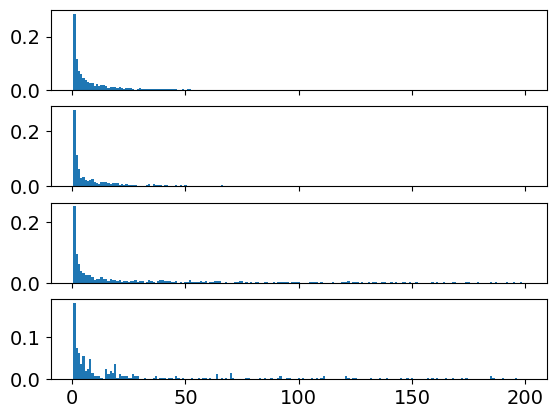

In [52]:
fig,axes=plt.subplots(4,1,sharex=True)
h=axes[0].hist(exposures['grapevine'][1].gdf['value'],bins=np.arange(0.5,60,1),density=True)
h=axes[1].hist(exposures['grapevine'][2].gdf['value'],bins=np.arange(0.5,200,1),density=True)
h=axes[2].hist(exposures['grapevine'][4].gdf['value'],bins=np.arange(0.5,200,1),density=True)
h=axes[3].hist(exposures['grapevine'][8].gdf['value'],bins=np.arange(0.5,200,1),density=True)

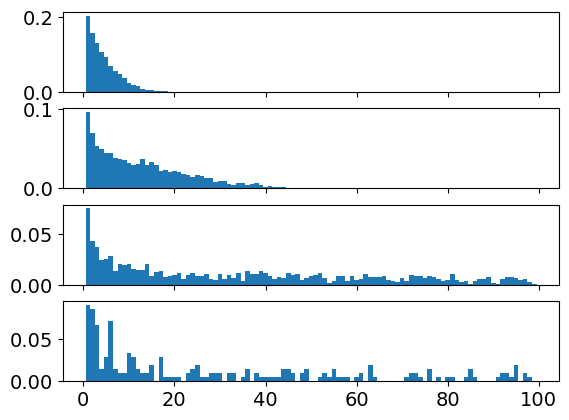

In [51]:
fig,axes=plt.subplots(4,1,sharex=True)
h=axes[0].hist(exposures['wheat'][1].gdf['value'],bins=np.arange(0.5,40,1),density=True)
h=axes[1].hist(exposures['wheat'][2].gdf['value'],bins=np.arange(0.5,100,1),density=True)
h=axes[2].hist(exposures['wheat'][4].gdf['value'],bins=np.arange(0.5,100,1),density=True)
h=axes[3].hist(exposures['wheat'][8].gdf['value'],bins=np.arange(0.5,100,1),density=True)

This suggests that, the total area covered by all grid points of the exposure (exposure area) strongly increases (is inflated) with coarser resolution for grapevine but less so for wheat. Lets investigate this  for two crops (wheat, grapevine) and an $n_{thresh}$ of 1. We compute for each resolution the area covered by all exposure gridpoints relative to the area of all exposure gridpoints at 1km. This is what we call inflation factor.

In [53]:
exp_thresh=1
res=[1,2,4,8]

tot_area_fraction={c:[] for c in exposures.keys()}
inflation={c:[] for c in exposures.keys()}

for r in res:
    for c in exposures.keys():
        print(c, r,'km')
        exp=exposures[c][r].gdf[exposures[c][r].gdf['value']>=exp_thresh]
        exp1=exposures[c][1].gdf[exposures[c][1].gdf['value']>=exp_thresh]
        tot_area_fraction[c].append(exp['area_ha'].sum()/(100*exp['value'].size*r*r))
        inflation[c].append(exp['value'].size*r*r/exp1['value'].size)

tot_area_fraction['res']=res
inflation['res']=res
data_fraction=pd.DataFrame.from_dict(data=tot_area_fraction)
data_inflation=pd.DataFrame.from_dict(data=inflation)

Weizen 1 km
Reben 1 km
Weizen 2 km
Reben 2 km
Weizen 4 km
Reben 4 km
Weizen 8 km
Reben 8 km


Now plot the inflation factor. This is Figure A2 of the paper.

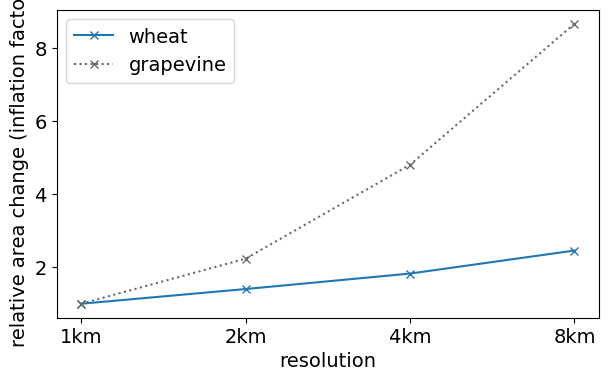

In [54]:
fig,ax=plt.subplots(figsize=(7,4))
ax.plot(data_inflation['wheat'],label='wheat',marker='x')
ax.plot(data_inflation['grapevine'],label='grapevine',marker='x',color='dimgrey',linestyle='dotted')
ax.set_xticks(data_inflation.index)
ax.set_xticklabels(['1km','2km','4km','8km'])
ax.set_xlabel('resolution')
ax.set_ylabel('relative area change (inflation factor)')
ax.legend()

In [90]:
fig.savefig(f'{figdir}/Figure_inflation_factor.png',dpi=200,bbox_inches='tight')
fig.savefig(f'{figdir}/Figure_inflation_factor.pdf',dpi=200,bbox_inches='tight')

Finally we can look at some interesting characteristics of the distributions for wheat and grapevine at different resolutions

In [56]:
exp_densities_n={c: [] for c in exposures.keys()}
exp_densities_ha={c: [] for c in exposures.keys()}
exp_densities_n_q={c: [] for c in exposures.keys()}
n_one_field={c: [] for c in exposures.keys()}
n_n_field={c: [] for c in exposures.keys()}

for c in exposures.keys():
    for res in resolutions:
        exp_densities_n[c].append(exposures[c][res].gdf.value.mean()/(res*res))
        exp_densities_ha[c].append(exposures[c][res].gdf['area_ha'][exposures[c][res].gdf['value']>=exp_thresh].mean()/(res*res*100)) #(exposures[c][res].gdf.area_ha.mean()/(res*res))

        p50=exposures[c][res].gdf.value.quantile(q=0.5)
        exp_densities_n_q[c].append(exposures[c][res].gdf.value[exposures[c][res].gdf.value<p50].mean()/(res*res))
        n_one_field[c].append(exposures[c][res].gdf.value[exposures[c][res].gdf.value==1].count()/len(exposures[c][res].gdf))
        n_n_field[c].append(exposures[c][res].gdf.value[exposures[c][res].gdf.value<=10].count()/len(exposures[c][res].gdf))

For example the fraction of grid cells with only one field 

In [58]:
n_n_field

{'Weizen': [0.9294507085962553,
  0.501032753024491,
  0.2883046237533998,
  0.2398921832884097],
 'Reben': [0.6351763169351328,
  0.5884645362431801,
  0.5318840579710145,
  0.42765273311897106]}

Or the fraction of grid cells with less than 10 fields

In [59]:
n_n_field

{'Weizen': [0.9294507085962553,
  0.501032753024491,
  0.2883046237533998,
  0.2398921832884097],
 'Reben': [0.6351763169351328,
  0.5884645362431801,
  0.5318840579710145,
  0.42765273311897106]}

Or the average cropland number and area densities

In [60]:
exp_densities_n

{'Weizen': [4.567601117202855,
  3.257229271171437,
  2.5019832275611966,
  1.8596276954177897],
 'Reben': [36.73008271658685,
  16.439789555728762,
  7.642119565217391,
  4.238796221864952]}

In [61]:
exp_densities_ha

{'Weizen': [0.07275252805318928,
  0.05188098913323848,
  0.039851466947539715,
  0.029620059328258966],
 'Reben': [0.0540474426964753,
  0.024190759133632844,
  0.011245197090018455,
  0.006237287775010238]}

or the median number density

In [62]:
exp_densities_n_q

{'Weizen': [1.8482367758186398,
  1.0504716981132076,
  0.6620412844036697,
  0.3236486486486487],
 'Reben': [1.8252516010978956,
  0.474,
  0.15090090090090091,
  0.07648026315789473]}

Now lets investigate how increasing the minimum number of fields within a grid cell $n_{thresh}$ reduces the fraction of total crop area included in the exposure. Lets compute this fraction in terms of area fraction and fraction of fields. For that we re-read the exposure data to include all crops and focus on spatial resolutions of 1km and 8km

In [40]:
croptypes = ['wheat','grapevine','Weizen_Mais_Raps_Gerste','Mais','Raps','Gerste']

resolutions=[1,8]
exposures={}
for croptype in croptypes:
    exposures[croptype]={res:{} for res in resolutions}

    if croptype=='grapevine':
        resolution=1
    else:
        resolution=8


    if resolution>1:
                exposure_file = f"C:/Users/F80840370/projects/scClim/climada/data/scClim/exposure/GIS/{croptype}_{resolution}km.gpkg" #Arealstatistik/'+croptype+'_latlon.hdf5'
    else:
                exposure_file = f"C:/Users/F80840370/projects/scClim/climada/data/scClim/exposure/GIS/{croptype}.gpkg" #Arealstatistik/'+croptype+'_latlon.hdf5'

    exposures[croptype][resolution] = exposure_from_gpd(exposure_file,
                                        description=croptype,
                                        value_colname='n_fields',
                                       value_unit='')


Get the fractions for exposure thresholds between 1 and 300 and resolution of 1km for grapevine and 8km for wheat.

In [41]:
#get data
exposure_threshs=np.arange(1,300,2)
area_fraction={}
n_fraction={}

#loop over all crops
for c in exposures.keys():
     print(c)
     if c=='grapevine':
             res=1
     else: 
             res=8
     af=[] #area fraction
     nf=[] #number fraction
     for exp_thresh in exposure_threshs:
          af.append(exposures[c][res].gdf[exposures[c][res].gdf['value']>=exp_thresh]['area_ha'].sum()/exposures[c][res].gdf['area_ha'].sum())
          nf.append(exposures[c][res].gdf[exposures[c][res].gdf['value']>=exp_thresh]['value'].sum()/exposures[c][res].gdf['value'].sum())
     
     #fill dictionary and set names
     area_fraction[f'{en_names[c]} ({res}km)']=af
     n_fraction[f'{en_names[c]} ({res}km)']=nf

#create pandas Dataframe with exposure threshold as index and fractions for each croptypes as columns
area_fraction['exp_thresh']=exposure_threshs
data_area_fraction=pd.DataFrame.from_dict(data=area_fraction)
n_fraction['exp_thresh']=exposure_threshs
data_n_fraction=pd.DataFrame.from_dict(data=n_fraction)

#create subsets of these Dataframes to facilitate plotting

#number fraction
df=data_n_fraction.set_index('exp_thresh')
df_grapevine=df['grapevine (1km)']
df_field=df['field crops (8km)']
df=df.drop('grapevine (1km)',axis=1)
df=df.drop('field crops (8km)',axis=1)

#area fraction
df2=data_area_fraction.set_index('exp_thresh')
df2_grapevine=df2['grapevine (1km)']
df2_field=df2['field crops (8km)']
df2=df2.drop('grapevine (1km)',axis=1)
df2=df2.drop('field crops (8km)',axis=1)

Weizen
Reben
Weizen_Mais_Raps_Gerste
Mais
Raps
Gerste


Now plot this in a Figure (Figure A3 of the paper)

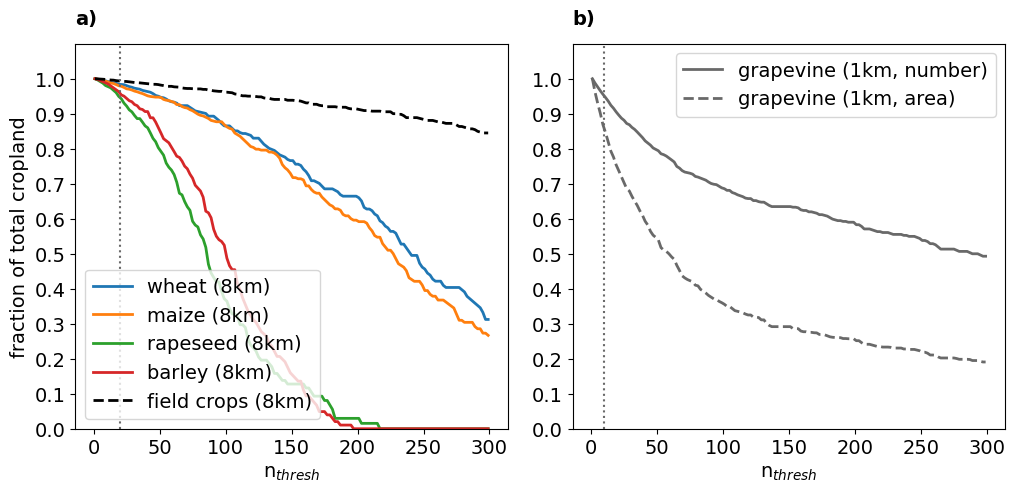

In [42]:
labels=['a)','b)']
#fontsizes
font_s=14
font_l=20
import matplotlib
matplotlib.rcParams.update({'font.size': font_s, 'axes.labelsize':font_s})

fig,axs=plt.subplots(1,2,figsize=(12,5))
plt.subplots_adjust(wspace=0.15)
df.plot(ax=axs[0],linewidth=2)

df_field.plot(ax=axs[0],linewidth=2,color='k',linestyle='dashed')

df_grapevine.plot(ax=axs[1],color='dimgrey',linewidth=2,label='grapevine (1km, number)')
df2_grapevine.plot(ax=axs[1],color='dimgrey',linewidth=2,linestyle='dashed',label='grapevine (1km, area)')
axs[1].legend()
axs[0].legend()
axs[0].set_ylabel('fraction of total cropland')
#plot horizontal thresholds
axs[0].axvline(x=20,color='dimgrey',linestyle='dotted')
axs[1].axvline(x=10,color='dimgrey',linestyle='dotted')
for i,ax in enumerate(axs):
    ax.text(0,1.05,labels[i],
                    transform=ax.transAxes,fontweight='bold')
    ax.set_xlabel(r'n$_{thresh}$')
    ax.set_ylim(0,1.1)
    ax.set_yticks(np.arange(0.,1.1,0.1))




In [ ]:
fig.savefig(f'{figdir}/Figure_A3.png',dpi=200,bbox_inches='tight')
fig.savefig(f'{figdir}/Figure_A3.pdf',dpi=200,bbox_inches='tight')